# Executive Summary 

            
The goal of this project is to identify duplicate questions i.e. questions of similar meaning given 2 questions on Quora. The competition was hosted on Kaggle and all the resources are freely available. Quora has provided labeled data identifying duplicates and the prediction of the models is tested on some part of this labeled set i.e. the test set. The success of the predictions is measured in terms of the following metrics:

- Log loss: $$ \sum_i −(𝑦_i 𝑙𝑜𝑔(ŷ_i ) + (1 − 𝑦_i) 𝑙𝑜𝑔(1 − ŷ_i )) $$
y = true label 
ŷ = predicted probability of a pair being duplicate

- Accuracy of the predictions

The study is divided into 4 parts:
- **Exploratory Data Analysis:** The analysis gives us an idea about the data at hand to tackle it most appropriately while modeling
- **Data Cleaning and Root Word Generation:** Raw text data is cleaned, and root words are generated from the words in the text to reduce the vocabulary for faster modeling 
- **Predictive Modeling with Classical Techniques:** In this section, features are extracted using character counts, term frequency-inverse document frequency (TF-IDF) along with cosine similarity. Common models are trained with these features
- **Predictive Modeling with Advanced Techniques:** Various Neural Network Architectures are tried with word embeddings created from questions’ text




Following is the summary of various models on the validation set: 

| Model | Avg-Precision |F1-Score|
| :-: | :-: |:-: |
|Char counts & char length difference with Logistic Regression| 0.58|65%|
| Char counts & char length difference with Random Forest | 0.55 | 68%|
| Char counts & char length difference with XGBoost | 0.55 |68%|
| Tf-idf & char length difference with Logistic Regression | 0.58 |65%|
| Tf-idf & char length difference with Random Forest | 0.47 |0.50|
| Tf-idf & char length difference with XGBoost | 0.55|67%|
| Sentence Embeddings based Neural Network architecture | 0.47 |77%|
| Word embeddings and LSTM based Neural Network architecture | 0.45 |77%|
| Word embeddings and CNN architecture | 0.43 |79%|

CNN model is tried on the Kaggle's test set and the best log-loss score is 0.41 


# Importing Libraries and Data

In [107]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import nltk
import scipy
from scipy import spatial
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import seaborn as sns
from matplotlib import pyplot as plt
from keras import Sequential
from keras.layers import Embedding,Bidirectional, LSTM, add, multiply, Conv1D, GlobalAveragePooling1D, MaxPooling1D, Lambda, Flatten, Dense, Input, merge, concatenate, Dropout, BatchNormalization
from keras import Model
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, Tokenizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from numpy.linalg import norm
#from qqp_utils import *
from keras.callbacks import EarlyStopping
from collections import Counter
import itertools
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
import keras.backend as K
from keras.optimizers import Adam

In [4]:
train_df = pd.read_csv("train.csv")
#test_df = pd.read_csv("test.csv")

In [8]:
test_df = pd.read_csv("test3.csv")

In [10]:
test_df.shape

(2345796, 3)

# EDA

In [11]:
train_df.shape

(404290, 6)

In [12]:
train_df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Distribution of Target Class 

In [13]:
train_df["is_duplicate"].value_counts(normalize = True)

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

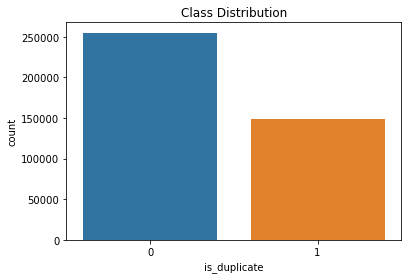

In [14]:
ax = sns.countplot(train_df["is_duplicate"])
ax.set_title("Class Distribution");

## Questions Analysis 

In [15]:
train_df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [16]:
train_df["question1"] = train_df["question1"].astype(str)
train_df["question2"] = train_df["question2"].astype(str)

In [17]:
max(train_df["question2"].apply(len))

1169

### Distribution of Questions 

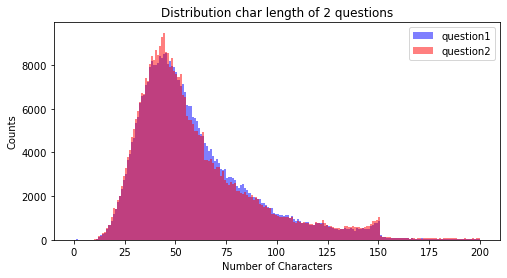

In [18]:
plt.figure(figsize = (8,4))
plt.hist(train_df["question1"].apply(len), bins = 200, range = [0,200], color = "b", alpha = 0.5)
plt.hist(train_df["question2"].apply(len), bins = 200, range = [0,200], color = "r", alpha = 0.5)
plt.title("Distribution char length of 2 questions")
plt.xlabel("Number of Characters")
plt.ylabel("Counts")
plt.legend(["question1", "question2"]);

The 2 questions have almost identical distribution  in terms of number of characters

### Distribution of difference in lengths by class 

In [19]:
len1 = train_df["question1"].apply(len)
len2 = train_df["question2"].apply(len)
diff_len = np.abs(len1-len2) 

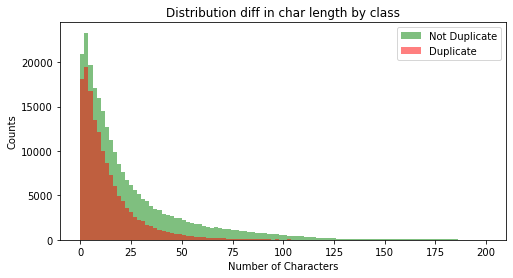

In [20]:
plt.figure(figsize = (8,4))
plt.hist(diff_len[train_df["is_duplicate"]==0], bins = 100, range = [0,200], color = "g", alpha =0.5)
plt.hist(diff_len[train_df["is_duplicate"]==1], bins = 100, range = [0,200], color = "r", alpha = 0.5)
plt.title("Distribution diff in char length by class")
plt.xlabel("Number of Characters")
plt.ylabel("Counts")
plt.legend(["Not Duplicate", "Duplicate"]);

Duplicate class the difference between characters is less 

# Data Cleaning and Root Word Generation:
Following tasks are addressed in this section:
- Cleaning
- Lemmatization / Stemming
- Dividing into training and test set

## Cleaning
Steps:
- Lowercase
- Tokenize
- Remove Stopwords
- Remove non alpha numeric characters

In [21]:
#Caching the stopwords
stopwords_eng = stopwords.words("english")

In [22]:
def clean_data(text):
    text = text.lower()
    words = nltk.word_tokenize(text)
    words = [w for w in words if w not in stopwords_eng and w.isalnum()]
    return words

In [26]:
q1 = train_df["question1"].apply(clean_data)
q2 = train_df["question2"].apply(clean_data)

## Lemmatize / Stem

In [23]:
lemma = WordNetLemmatizer()
def lemmatize(text):
    return " ".join([lemma.lemmatize(w) for w in text])    

In [ ]:
q1_lem = q1.apply(lemmatize)
q2_lem = q2.apply(lemmatize) 

In [28]:
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(w) for w in text]) 

In [29]:
q1_stem = q1.apply(stem_words)
q2_stem = q2.apply(stem_words) 

Stemming works much faster

## Dividing the Data 

In [131]:
RANDOM_STATE = 24
ind_train , ind_test, y_train, y_test = train_test_split(np.arange(0,train_df.shape[0]), train_df["is_duplicate"], train_size = 0.95, stratify = train_df["is_duplicate"], random_state = RANDOM_STATE)

In [31]:
X_clean = pd.DataFrame({"q1":q1_stem, "q2":q2_stem})
X_clean.to_csv("X_clean_new.csv", index = False)
X_train, X_test = X_clean.iloc[ind_train, :], X_clean.iloc[ind_test, :]

In [132]:
# X_clean = pd.read_csv("X_clean.csv")
# X_clean["q1"] = X_clean["q1"].apply(str)
# X_clean["q2"] = X_clean["q2"].apply(str)
# X_train, X_test = X_clean.iloc[ind_train, :], X_clean.iloc[ind_test, :]

# Predictive Modeling - Traditional Methods

## Difference in char length  & Char count similarity Approach
- Count characters (2-6)
- Find cosine similarity between 2 questions' char counts
- Apply predictive models with cosine similarity and length difference between questions as features

### Diff Lengths 

In [133]:
diff_len_train = diff_len[ind_train]
diff_len_test = diff_len[ind_test]

### Char Counts

In [134]:
Questions_train = pd.concat([X_train["q1"], X_train["q2"]], axis = 0)

In [133]:
count_vect = CountVectorizer(analyzer = "char", ngram_range = (2,6))
count_vect.fit(Questions_train);

In [134]:
charc_q1_train = count_vect.transform(X_train["q1"])
charc_q2_train = count_vect.transform(X_train["q2"])
charc_q1_test = count_vect.transform(X_test["q1"])
charc_q2_test = count_vect.transform(X_test["q2"])

### Cosine Similarity

In [55]:
def cosine_sim(vect1, vect2):
    cos_sim = np.empty([vect1.shape[0], 1])
    for i,vs in enumerate(zip(vect1, vect2)):
        cos_sim[i] = (float(cosine_similarity(vs[0], vs[1])))
    return cos_sim

In [309]:
cos_sim_train = cosine_sim(charc_q1_train, charc_q2_train)
#pd.DataFrame({"cos_sim":list(cos_sim_train[:,0])}).to_csv("cos_sim_train.csv", index = False)

In [135]:
# cos_sim_train = pd.read_csv("cos_sim_train.csv")
# cos_sim_train = np.array(pd.read_csv("cos_sim_train.csv"))

In [311]:
cos_sim_test = cosine_sim(charc_q1_test, charc_q2_test)
#pd.DataFrame({"cos_sim":list(cos_sim_test[:,0])}).to_csv("cos_sim_test.csv", index = False)

In [136]:
# cos_sim_test = pd.read_csv("cos_sim_test.csv")
# cos_sim_test = np.array(pd.read_csv("cos_sim_test.csv"))

### Combining Features & Normalizing 
- Combine diff_len and cos_sim with char counts as 2 feature for the model
- Normalize using min max scaler

In [137]:
Features_train = pd.DataFrame({"diff_len": diff_len_train, "cos_sim": list(cos_sim_train)})
Features_test = pd.DataFrame({"diff_len": diff_len_test, "cos_sim": list(cos_sim_test)})

In [138]:
scaler = MinMaxScaler()
scaler.fit(Features_train)
Features_train_n = scaler.transform(Features_train)
Features_test_n = scaler.transform(Features_test)

### Modeling 

#### Logistic Regression

In [315]:
Summary_CS = pd.DataFrame(columns = ["Model", "Log Loss","Accuracy"])

In [316]:
lr = LogisticRegression()
lr.fit(Features_train_n , y_train)
preds_train = lr.predict_proba(Features_train_n)[:,1];

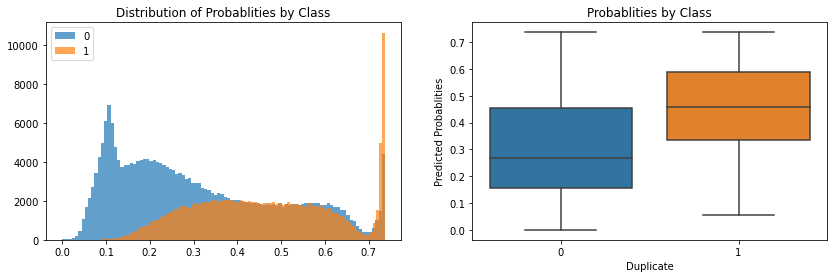

In [317]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [318]:
preds_test = lr.predict_proba(Features_test_n)[:,1]
log_loss_score = log_loss(y_test, preds_test)
accuracy = lr.score(Features_test_n, y_test)

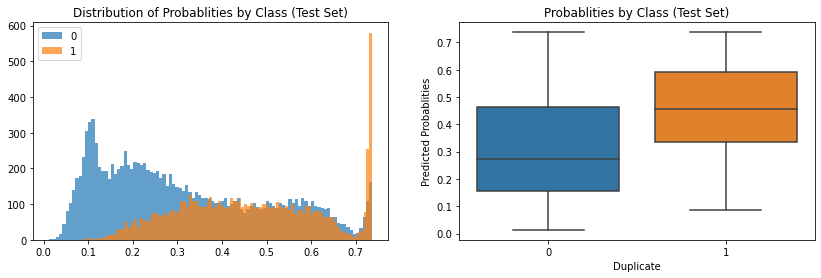

In [319]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [320]:
Summary_CS  = Summary_CS.append({"Model":"Diff_len & Char_counts with Logistic Regression", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [321]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.58,0.65


#### Random Forest 

In [322]:
rf = RandomForestClassifier(max_depth = 5)
rf.fit(Features_train_n , y_train)
preds_train = rf.predict_proba(Features_train_n)[:,1];

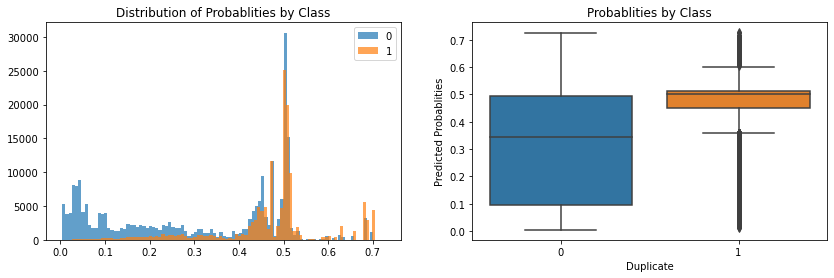

In [323]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [324]:
preds_test = rf.predict_proba(Features_test_n)[:,1]
log_loss_score = log_loss(y_test, preds_test)
accuracy = rf.score(Features_test_n, y_test)

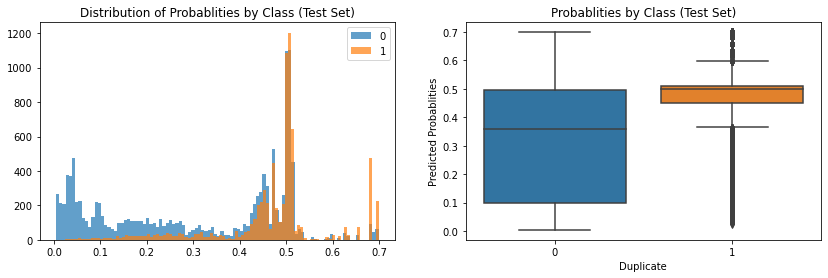

In [325]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [326]:
Summary_CS  = Summary_CS.append({"Model":"Diff_len & Char_counts with Random Forest", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [327]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.58,0.65
1,Diff_len & Char_counts with Random Forest,0.55,0.68


#### XGBoost 

In [328]:
xgb = XGBClassifier(max_depth = 5)
xgb.fit(Features_train_n , y_train)
preds_train = xgb.predict_proba(Features_train_n)[:,1];

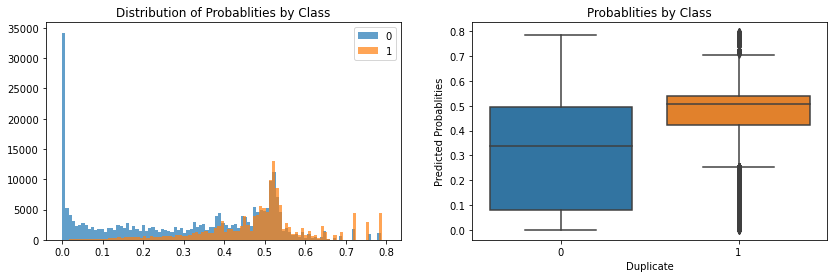

In [329]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [330]:
preds_test = xgb.predict_proba(Features_test_n)[:,1]
log_loss_score = log_loss(y_test, preds_test)
accuracy = xgb.score(Features_test_n, y_test)

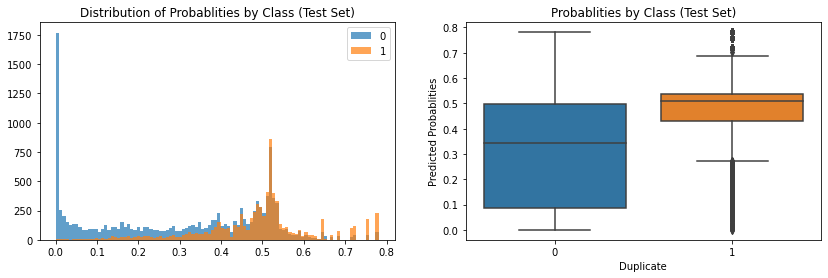

In [331]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [332]:
Summary_CS  = Summary_CS.append({"Model":"Diff_len & Char_counts with XGBoost", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [333]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.58,0.65
1,Diff_len & Char_counts with Random Forest,0.55,0.68
2,Diff_len & Char_counts with XGBoost,0.55,0.68


## Difference in char length & Tf-idf cosine similarity Approach
- Tf-idf characters (2-6)
- Find cosine similarity between 2 questions' Tf-idf vectors
- Apply predictive models with cosine similarity and length difference between questions as features

### Tf-idf

In [334]:
tfidf_vect = TfidfVectorizer(analyzer = "char", ngram_range = (2,6))
tfidf_vect.fit(Questions_train);

In [335]:
tfidf_q1_train = tfidf_vect.transform(X_train["q1"])
tfidf_q2_train = tfidf_vect.transform(X_train["q2"])
tfidf_q1_test = tfidf_vect.transform(X_test["q1"])
tfidf_q2_test = tfidf_vect.transform(X_test["q2"])

### Cosine Similarity 

In [336]:
cos_sim_train2 = cosine_sim(tfidf_q1_train, tfidf_q2_train)
pd.DataFrame({"cos_sim":list(cos_sim_train2[:,0])}).to_csv("cos_sim_train2.csv", index = False)

In [337]:
cos_sim_test2 = cosine_sim(tfidf_q1_test, tfidf_q2_test)
pd.DataFrame({"cos_sim":list(cos_sim_test2[:,0])}).to_csv("cos_sim_test2.csv", index = False)

In [338]:
# cos_sim_train2 = np.array(pd.read_csv("cos_sim_train2.csv"))
# cos_sim_test2 = np.array(pd.read_csv("cos_sim_test2.csv"))

### Combining Features
- Combine diff_len and cos_sim with char counts as 2 feature for the model

In [339]:
Features_train2 = pd.DataFrame({"diff_len": diff_len_train, "cos_sim": list(cos_sim_train2)})
Features_test2 = pd.DataFrame({"diff_len": diff_len_test, "cos_sim": list(cos_sim_test2)})

In [340]:
scaler = MinMaxScaler()
scaler.fit(Features_train)
Features_train_n2 = scaler.transform(Features_train2)
Features_test_n2 = scaler.transform(Features_test2)

### Modeling

#### Logistic Regression

In [341]:
lr = LogisticRegression()
lr.fit(Features_train_n2 , y_train);

In [342]:
preds_train = lr.predict_proba(Features_train_n2)[:,1]

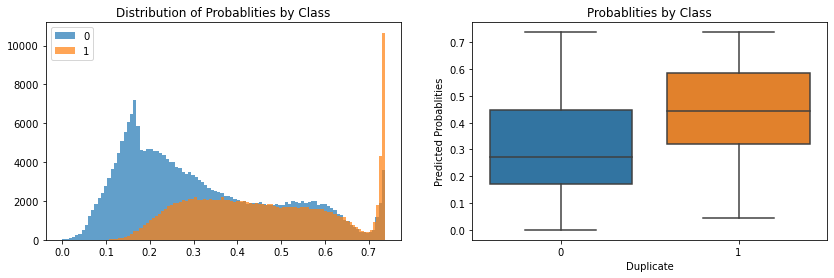

In [343]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [344]:
preds_test = lr.predict_proba(Features_test_n2)[:,1]
log_loss_score = log_loss(y_test, preds_test)
accuracy = lr.score(Features_test_n2, y_test)

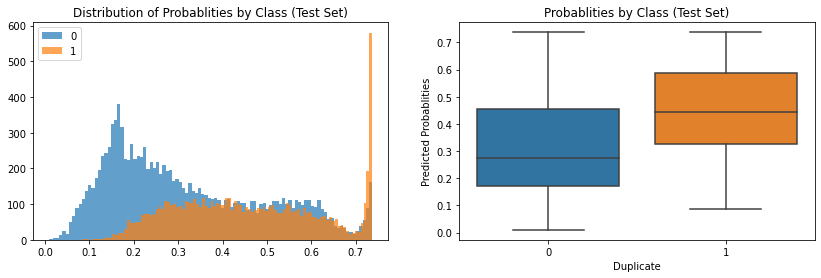

In [345]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [346]:
Summary_CS  = Summary_CS.append({"Model":"Diff_len & Tf-idf with Logistic Regression", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

#### Random Forest 

In [347]:
rf = RandomForestClassifier(max_depth = 5)
rf.fit(Features_train_n2 , y_train);

In [348]:
preds_train = rf.predict_proba(Features_train_n2)[:,1]

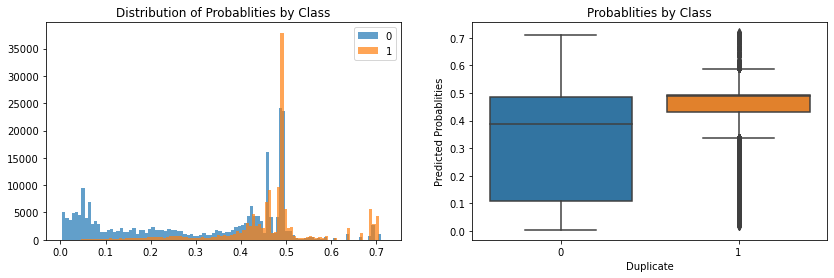

In [349]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [350]:
preds_test = rf.predict_proba(Features_test_n2)[:,1]
log_loss_score = log_loss(y_test, preds_test)
accuracy = rf.score(Features_test_n2, y_test)

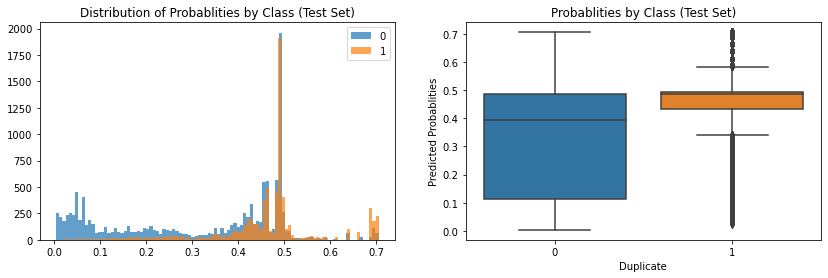

In [351]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [352]:
Summary_CS  = Summary_CS.append({"Model":"Diff_len & Tf-idf with Random Forest", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [353]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.58,0.65
1,Diff_len & Char_counts with Random Forest,0.55,0.68
2,Diff_len & Char_counts with XGBoost,0.55,0.68
3,Diff_len & Tf-idf with Logistic Regression,0.58,0.65
4,Diff_len & Tf-idf with Random Forest,0.56,0.67


#### XGBoost 

In [354]:
xgb = XGBClassifier(max_depth = 5)
xgb.fit(Features_train_n2 , y_train);

In [355]:
preds_train = xgb.predict_proba(Features_train_n2)[:,1]

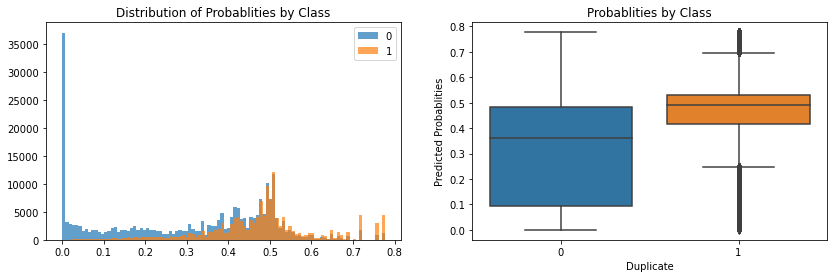

In [356]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [357]:
preds_test = xgb.predict_proba(Features_test_n2)[:,1]
log_loss_score = log_loss(y_test, preds_test)
accuracy = xgb.score(Features_test_n2, y_test)

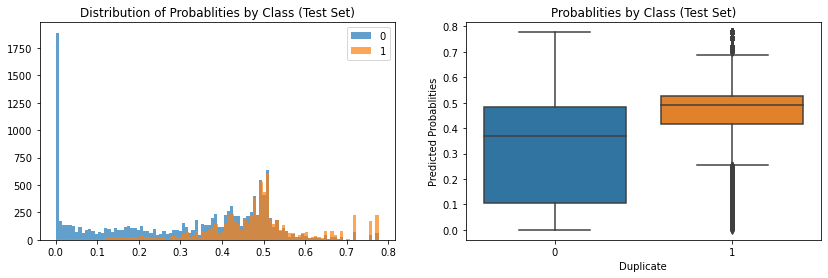

In [358]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [359]:
Summary_CS  = Summary_CS.append({"Model":"Diff_len & Tf-idf with XGBoost", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [360]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.58,0.65
1,Diff_len & Char_counts with Random Forest,0.55,0.68
2,Diff_len & Char_counts with XGBoost,0.55,0.68
3,Diff_len & Tf-idf with Logistic Regression,0.58,0.65
4,Diff_len & Tf-idf with Random Forest,0.56,0.67
5,Diff_len & Tf-idf with XGBoost,0.55,0.67


# Predictive Modeling - Advanced Methods

##  Sentence Embedding with Neural Networks  Approach
- Use pre trained Glove word embeddings
- Calculate average word embeddings for sentences from words
- Build a Neural Network Architecture

### Import Glove word embeddings 

In [32]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding='utf8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [255]:
embeddings_index = {}
f = open(r'glove.840B.300d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [257]:
word_to_vec_map = embeddings_index

In [293]:
#c
def get_glove_vec(word):
    try:
        return word_to_vec_map[word]
    except:
        return np.zeros((300,))

### Calculate average word embeddings for sentences from words

In [35]:
def sentence_to_avg(sentence, word_to_vec_map = word_to_vec_map):
    words = sentence.split()
    avg = np.zeros(50)
    total = 0
    for w in words:
        total += get_glove_vec(w)
    if len(words) != 0:
        avg = total/(len(words))
    return list(avg)

### Build the Neural Network Architecture

In [77]:
# Stopping the model after 5 values
early_stopping = EarlyStopping(monitor="val_loss", patience = 5)

In [366]:
#Creating sentence embeddings
X_train_emb_q1 = list(X_train["q1"].apply(sentence_to_avg))
X_train_emb_q2 = list(X_train["q2"].apply(sentence_to_avg))
X_test_emb_q1 = list(X_test["q1"].apply(sentence_to_avg))
X_test_emb_q2 = list(X_test["q2"].apply(sentence_to_avg));

In [367]:
def build_sentence_avg_model():
    #Inputs
    input_q1 = Input(shape = (50,), name = "Input_q1")
    input_q2 = Input(shape = (50,), name = "Input_q2")
    #Merge inputs
    merge_q = concatenate([input_q1, input_q2], name = "Inputs_merged")
    merge_q = Dense(128, activation='relu', name = "Dense1")(merge_q)
    merge_q = BatchNormalization(name = "BatchNorm1")(merge_q)
    merge_q = Dropout(0.2, name = "DropOut1")(merge_q)
    merge_q = Dense(64, activation='relu', name = "Dense2")(merge_q)
    merge_q = BatchNormalization(name = "BatchNorm2")(merge_q)
    merge_q = Dropout(0.2, name = "DropOut2")(merge_q)
    #Output layer
    output = Dense(1, activation='sigmoid', name = "Output")(merge_q)
    model = Model(inputs=[input_q1,input_q2], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [368]:
sentence_avg_model = build_sentence_avg_model()

In [369]:
sentence_avg_model.fit([X_train_emb_q1,X_train_emb_q2], np.array(y_train),  validation_data = ([X_test_emb_q1,X_test_emb_q2], np.array(y_test)),  epochs=50, batch_size=1024, shuffle=True, callbacks = [early_stopping])

Train on 384075 samples, validate on 20215 samples
Epoch 1/50
384075/384075 [==============================] - 15s 39us/step - loss: 0.6282 - acc: 0.6591 - val_loss: 0.5709 - val_acc: 0.7087
Epoch 2/50
384075/384075 [==============================] - 14s 38us/step - loss: 0.5616 - acc: 0.7050 - val_loss: 0.5347 - val_acc: 0.7240
Epoch 3/50
384075/384075 [==============================] - 15s 38us/step - loss: 0.5410 - acc: 0.7188 - val_loss: 0.5218 - val_acc: 0.7300
Epoch 4/50
384075/384075 [==============================] - 14s 38us/step - loss: 0.5295 - acc: 0.7270 - val_loss: 0.5121 - val_acc: 0.7376
Epoch 5/50
384075/384075 [==============================] - 15s 38us/step - loss: 0.5226 - acc: 0.7309 - val_loss: 0.5085 - val_acc: 0.7408
Epoch 6/50
384075/384075 [==============================] - 14s 38us/step - loss: 0.5161 - acc: 0.7349 - val_loss: 0.5039 - val_acc: 0.7433
Epoch 7/50
384075/384075 [==============================] - 14s 38us/step - loss: 0.5111 - acc: 0.7386 - val_

In [370]:
preds_train = sentence_avg_model.predict([X_train_emb_q1,X_train_emb_q2])[:,0];

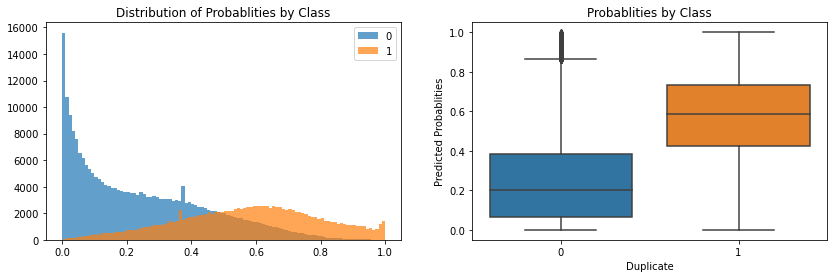

In [371]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [372]:
preds_test = sentence_avg_model.predict([X_test_emb_q1,X_test_emb_q2])[:,0]
accuracy = accuracy_score(y_test, [1 if p > 0.5 else 0 for p in preds_test]);

In [373]:
log_loss_score = log_loss(y_test, preds_test)

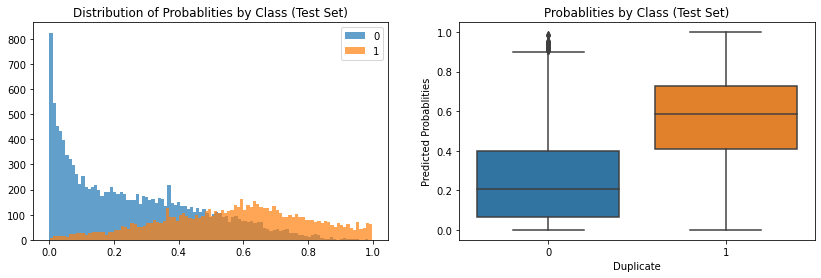

In [374]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [375]:
Summary_CS  = Summary_CS.append({"Model":"Avg. Word Embeddings & Neural Network", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [376]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.58,0.65
1,Diff_len & Char_counts with Random Forest,0.55,0.68
2,Diff_len & Char_counts with XGBoost,0.55,0.68
3,Diff_len & Tf-idf with Logistic Regression,0.58,0.65
4,Diff_len & Tf-idf with Random Forest,0.56,0.67
5,Diff_len & Tf-idf with XGBoost,0.55,0.67
6,Avg. Word Embeddings & Neural Network,0.47,0.77


Observation:
- There is a huge improvement in the test log loss with the latest approach

##  Word Embeddings and LSTM Network
- Lemmatize both Questions
- Use pre trained Glove word embeddings in the Embedding Layer
- Build a Neural Network Architecture with the LSTM layer

### Import Glove word embeddings 
We use the Glove word embeddings imported earlier

In [139]:
VOCAB_DIM = 50000
SENTENCE_LEN = 60

In [260]:
def filter_glove(vocab_dict, dim = 300, num_words = VOCAB_DIM):
    embedding_matrix = np.zeros((num_words+1, dim))
    for word, i in vocab_dict.items():
        embedding_vector = get_glove_vec(word)
        if i == VOCAB_DIM:
            break;
        embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [141]:
tokenizer = Tokenizer(num_words = VOCAB_DIM)
tokenizer.fit_on_texts((Questions_train))
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 72336


In [261]:
glove_matrix = filter_glove(tokenizer.word_index)

## Creating embedding sequence 

In [143]:
sequences_q1 = tokenizer.texts_to_sequences(X_train["q1"])
sequences_q2 = tokenizer.texts_to_sequences(X_train["q2"])

In [144]:
sequences_test_q1 = tokenizer.texts_to_sequences(X_test["q1"])
sequences_test_q2 = tokenizer.texts_to_sequences(X_test["q2"])

In [145]:
pad_q1 = pad_sequences(sequences_q1, maxlen = SENTENCE_LEN, padding = "post", value = 0)
pad_q2 = pad_sequences(sequences_q2, maxlen = SENTENCE_LEN, padding = "post", value = 0)

In [146]:
pad_test_q1 = pad_sequences(sequences_test_q1, maxlen = SENTENCE_LEN, padding = "post", value = 0)
pad_test_q2 = pad_sequences(sequences_test_q2, maxlen = SENTENCE_LEN, padding = "post", value = 0)

### Build the Neural Network Architecture

In [385]:
def lstm_model(glove_matrix):
    input_q1 = Input(shape = (SENTENCE_LEN,))
    embedding_q1 = Embedding(input_dim = VOCAB_DIM + 1, output_dim = 50, 
                         embeddings_initializer=Constant(glove_matrix), 
                         input_length=SENTENCE_LEN, trainable=False, name = "embedding_q1")(input_q1)
    input_q2 = Input(shape = (SENTENCE_LEN,))
    embedding_q2 = Embedding(input_dim = VOCAB_DIM + 1, output_dim = 50, 
                         embeddings_initializer=Constant(glove_matrix), 
                         input_length=SENTENCE_LEN, trainable=False, name = "embedding_q2")(input_q2)
    
    lstm_layers = Sequential(name = "Siamese_LSTM")
    lstm_layers.add(LSTM(64, dropout = 0.4, return_sequences = True, name = "LSTM_layer1" ))
    lstm_layers.add(LSTM(64, dropout = 0.4, name = "LSTM_layer2"))
    lstm_layers.add(Dense(64, name ="Dense_layer", activation='relu'))
    
    lstm_q1 = lstm_layers(embedding_q1)
    lstm_q2 = lstm_layers(embedding_q2)
    
    magic_input = Input(shape = (2,))
    magic_dense = Dense(64, activation = "relu")(magic_input)
    
    merge_all = concatenate([lstm_q1, lstm_q2, magic_dense], name = "Merge")
    merge_all = Dense(64, activation='relu', name = "Dense1")(merge_all)
    merge_all = BatchNormalization(name = "BatchNorm1")(merge_all)
    merge_all = Dropout(0.2, name = "DropOut1")(merge_all)
    output = Dense(1, activation='sigmoid', name = "Output")(merge_all)
    model = Model(inputs=[input_q1,input_q2,magic_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [386]:
lstm_model = lstm_model(glove_matrix)

In [389]:
lstm_model.fit([pad_q1,pad_q2,Features_train_n], y_train, validation_data = ([pad_test_q1,pad_test_q2, Features_test_n], np.array(y_test)) ,  epochs=5, batch_size=1024, shuffle=True, callbacks = [early_stopping])

Train on 384075 samples, validate on 20215 samples
Epoch 1/5
384075/384075 [==============================] - 2176s 6ms/step - loss: 0.4748 - acc: 0.7492 - val_loss: 0.4714 - val_acc: 0.7513
Epoch 2/5
384075/384075 [==============================] - 2119s 6ms/step - loss: 0.4718 - acc: 0.7520 - val_loss: 0.5208 - val_acc: 0.7146
Epoch 3/5
384075/384075 [==============================] - 2077s 5ms/step - loss: 0.4697 - acc: 0.7538 - val_loss: 0.4619 - val_acc: 0.7644
Epoch 4/5
384075/384075 [==============================] - 2074s 5ms/step - loss: 0.4670 - acc: 0.7555 - val_loss: 0.4919 - val_acc: 0.7350
Epoch 5/5
384075/384075 [==============================] - 8628s 22ms/step - loss: 0.4652 - acc: 0.7568 - val_loss: 0.4530 - val_acc: 0.7659


In [391]:
preds_train = lstm_model.predict([pad_q1,pad_q2, Features_train_n])[: ,0];

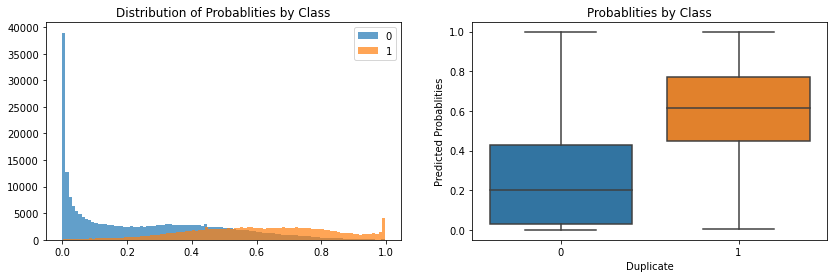

In [392]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [393]:
preds_test = lstm_model.predict([pad_test_q1,pad_test_q2,Features_test_n])[:,0];
accuracy = accuracy_score(y_test, [1 if p > 0.5 else 0 for p in preds_test]);
#preds_test[preds_test < 0.00001] = 0.00001 
#preds_test[preds_test  > 0.99999] =  0.99999

In [394]:
log_loss_score = log_loss(y_test, preds_test)

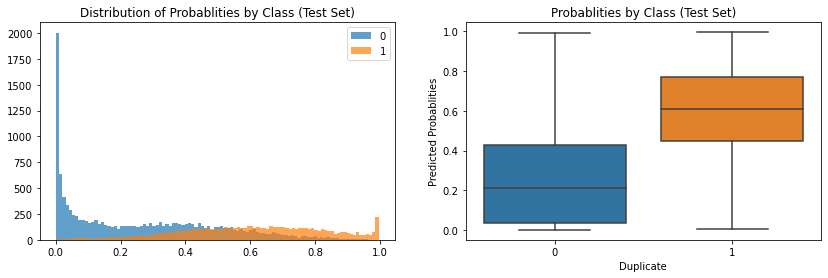

In [395]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [396]:
Summary_CS  = Summary_CS.append({"Model":"LSTM Architecture", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [397]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.58,0.65
1,Diff_len & Char_counts with Random Forest,0.55,0.68
2,Diff_len & Char_counts with XGBoost,0.55,0.68
3,Diff_len & Tf-idf with Logistic Regression,0.58,0.65
4,Diff_len & Tf-idf with Random Forest,0.56,0.67
5,Diff_len & Tf-idf with XGBoost,0.55,0.67
6,Avg. Word Embeddings & Neural Network,0.47,0.77
7,LSTM Architecture,0.45,0.77


##  Word Embeddings and CNN
- Use pre trained Glove word embeddings in the Embedding Layer
- Build a Neural Network Architecture with the Embedding, CNN and Dense Layer

### Import Glove word embeddings 
We use the Glove word embeddings imported earlier

In [89]:
glove_matrix = filter_glove(tokenizer.word_index)

### Build the Neural Network Architecture

In [392]:
#c
def build_cnn_arch(glove_matrix):
    input_q1 = Input(shape = (SENTENCE_LEN,))
    embedding_q1 = Embedding(input_dim = VOCAB_DIM + 1, output_dim = 300, 
                         embeddings_initializer=Constant(glove_matrix), 
                         input_length=SENTENCE_LEN, trainable=False, name = "embedding_q1")(input_q1)
    input_q2 = Input(shape = (SENTENCE_LEN,))
    embedding_q2 = Embedding(input_dim = VOCAB_DIM + 1, output_dim = 300, 
                         embeddings_initializer=Constant(glove_matrix), 
                         input_length= SENTENCE_LEN, trainable=False, name = "embedding_q2")(input_q2)
    

    
    cnn_layers = Sequential(name = "Siamese_CNN_layers")
    cnn_layers.add(Conv1D(filters=256, kernel_size=3,input_shape = (SENTENCE_LEN,300), padding='same', activation='relu', name = "Convolution_layer"))
    cnn_layers.add(GlobalAveragePooling1D(name = "Average_Pooling_layer"))

    cnn_layers.add(Dense(128, activation='relu', name = "Dense_layer1"))
    cnn_layers.add(BatchNormalization(name = "Batch_Normalization_layer1"))
    cnn_layers.add(Dropout(0.2, name = "Dropuout_layer1"))
#     cnn_layers.add(Dense(128, activation='relu', name = "Dense_layer2"))
#     cnn_layers.add(BatchNormalization(name = "Batch_Normalization_layer2"))
#     cnn_layers.add(Dropout(0.2, name = "Dropuout_layer2"))
    cnn_q1k2 = cnn_layers(embedding_q1)
    cnn_q2k2 = cnn_layers(embedding_q2)


    magic_input = Input(shape = (2,))
    magic_dense = Dense(128, activation = "relu", name = "Dense_magic_layer")(magic_input)
    #magic_dense2 = Dense(128, activation = "relu", name = "Dense_magic_layer2")(magic_dense)
    
    merge_all = concatenate([cnn_q1k2, cnn_q2k2, magic_dense])
#     merge_all = Dense(256, activation='relu', name = "Common_Dense_layer1")(merge_all)
#     merge_all = BatchNormalization(name = "Batch_Normalization_layer1")(merge_all)
#     merge_all = Dropout(0.2, name = "Dropout_layer1")(merge_all)
    merge_all = Dense(128, activation='relu', name = "Common_Dense_layer2")(merge_all)
    merge_all = BatchNormalization(name = "Batch_Normalization_layer2")(merge_all)
    merge_all = Dropout(0.2, name = "Dropout_layer2")(merge_all)
#     merge_all = Dense(128, activation='relu', name = "Common_Dense_layer3")(merge_all)
#     merge_all = BatchNormalization(name = "Batch_Normalization_layer3")(merge_all)
#     merge_all = Dropout(0.2, name = "Dropout_layer3")(merge_all)
    output = Dense(1, activation='sigmoid', name = "Output_layer")(merge_all)
    model = Model(inputs=[input_q1,input_q2,magic_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])
    return model

In [393]:
cnn_model = build_cnn_arch(glove_matrix)

In [149]:
cnn_model.fit([pad_q1,pad_q2,Features_train_n], y_train, validation_data = ([pad_test_q1,pad_test_q2, Features_test_n],y_test) ,  epochs=30, batch_size=1024, shuffle=True, callbacks = [early_stopping])

Train on 384075 samples, validate on 20215 samples
Epoch 1/30
384075/384075 [==============================] - 80s 208us/step - loss: 0.5423 - acc: 0.7074 - val_loss: 0.4802 - val_acc: 0.7465
Epoch 2/30
384075/384075 [==============================] - 80s 208us/step - loss: 0.4643 - acc: 0.7602 - val_loss: 0.4540 - val_acc: 0.7666
Epoch 3/30
 91136/384075 [======>.......................] - ETA: 59s - loss: 0.4477 - acc: 0.7713

KeyboardInterrupt: 

In [405]:
cnn_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_q1 (Embedding)        (None, 60, 50)       2500050     input_16[0][0]                   
__________________________________________________________________________________________________
embedding_q2 (Embedding)        (None, 60, 50)       2500050     input_17[0][0]                   
____________________________________________________________________________________________

In [406]:
preds_train = cnn_model.predict([pad_q1,pad_q2,Features_train_n])[:,0];

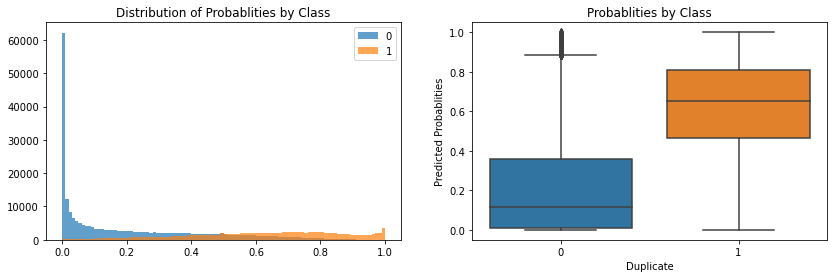

In [407]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [408]:
preds_test = cnn_model.predict([pad_test_q1,pad_test_q2,Features_test_n])[:,0]
accuracy = accuracy_score(y_test, [1 if p > 0.5 else 0 for p in preds_test]);

In [409]:
log_loss_score = log_loss(y_test, preds_test)

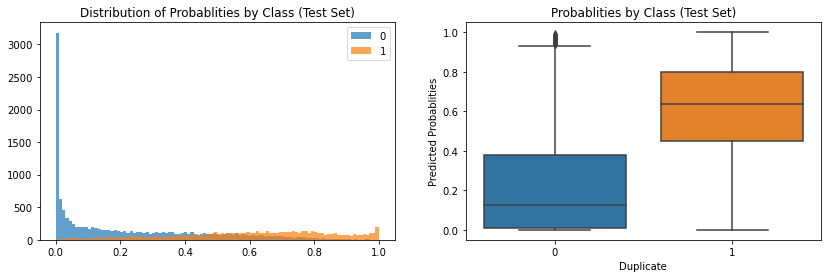

In [410]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = preds_labels, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [411]:
Summary_CS  = Summary_CS.append({"Model":"CNN Architecture", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [412]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.58,0.65
1,Diff_len & Char_counts with Random Forest,0.55,0.68
2,Diff_len & Char_counts with XGBoost,0.55,0.68
3,Diff_len & Tf-idf with Logistic Regression,0.58,0.65
4,Diff_len & Tf-idf with Random Forest,0.56,0.67
5,Diff_len & Tf-idf with XGBoost,0.55,0.67
6,Avg. Word Embeddings & Neural Network,0.47,0.77
7,LSTM Architecture,0.45,0.77
8,CNN Architecture,0.43,0.79


# Testing on Kaggle Test Set 

In [44]:
test_df["question1"] = test_df["question1"].astype(str)
test_df["question2"] = test_df["question2"].astype(str)

In [45]:
q1_test = test_df["question1"].apply(clean_data)

In [46]:
q2_test = test_df["question2"].apply(clean_data)

In [47]:
q1_stem_test = q1_test.apply(stem_words)
#q2_stem_test = q2_test.apply(stem_words) 

In [48]:
q2_stem_test = q2_test.apply(stem_words) 

In [49]:
X_clean_test = pd.DataFrame({"q1":q1_stem_test, "q2":q2_stem_test})

## Training on the complete data

In [50]:
Questions_train_all = pd.concat([X_clean["q1"], X_clean["q2"]], axis = 0)

### Cosine Similarity 

In [51]:
count_vect_final = CountVectorizer(analyzer = "char", ngram_range = (2,6))
count_vect_final.fit(Questions_train_all)

CountVectorizer(analyzer='char', ngram_range=(2, 6))

In [52]:
charc_q1_train_all = count_vect_final.transform(X_clean["q1"])
charc_q2_train_all = count_vect_final.transform(X_clean["q2"])
charc_q1_test_all = count_vect_final.transform(X_clean_test["q1"])
charc_q2_test_all = count_vect_final.transform(X_clean_test["q2"])

In [56]:
cos_sim_train_final = cosine_sim(charc_q1_train_all, charc_q2_train_all)

In [57]:
cos_sim_test_final = cosine_sim(charc_q1_test_all, charc_q2_test_all)

### Diff lengths 

In [117]:
len1 = train_df["question1"].apply(len)
len2 = train_df["question2"].apply(len)
diff_len = np.abs(len1 - len2) 

In [118]:
Features_train_all = pd.DataFrame({"diff_len": diff_len, "cos_sim": list(cos_sim_train_final)})

In [119]:
len1_test = test_df["question1"].apply(len)
len2_test = test_df["question2"].apply(len)
diff_len_test = np.abs(len1_test - len2_test) 

### Number of common words

In [214]:
def no_common_words(df):
    ws1 = df["q1"].split(" ")
    ws2 = df["q2"].split(" ")
    intersects = set(ws1).intersection( set(ws2) )
    unions = set(ws1).union( set(ws2) )
    if unions == 0:
        return 1
    common_ratio = len(intersects)/len(unions)
    return common_ratio

In [218]:
common_words = X_clean.apply(no_common_words, axis = 1)

In [219]:
common_words_test = X_clean_test.apply(no_common_words, axis = 1)

### Combining all the features

In [222]:
Features_train_all["common_words"] = common_words

In [ ]:
Features_test_all = pd.DataFrame({"diff_len": diff_len_test, "cos_sim": list(cos_sim_test_final)})

In [223]:
Features_test_all["common_words"] = common_words_test

In [70]:
Features_test_all.to_csv("features_test_all.csv", index  = False)

In [265]:
#Features_test_all = pd.read_csv("features_test_all.csv")

In [278]:
#Features_test_all["cos_sim"] = Features_test_all["cos_sim"].apply(lambda x:float(x[1:-1]))

## Data Preperation for the NN architecture

In [288]:
VOCAB_DIM = 60000
SENTENCE_LEN = 90

In [289]:
tokenizer_final = Tokenizer(num_words = VOCAB_DIM)
tokenizer_final.fit_on_texts((Questions_train_all))
word_index = tokenizer_final.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 61022


In [296]:
def filter_glove(vocab_dict, dim = 300, num_words = VOCAB_DIM):
    embedding_matrix = np.zeros((num_words+1, dim))
    for word, i in vocab_dict.items():
        embedding_vector = get_glove_vec(word)
        if i == VOCAB_DIM:
            break;
        embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [388]:
glove_matrix = filter_glove(tokenizer_final.word_index)

In [298]:
sequences_q1 = tokenizer_final.texts_to_sequences(X_clean["q1"])
sequences_q2 = tokenizer_final.texts_to_sequences(X_clean["q2"])

In [299]:
sequences_test_q1 = tokenizer_final.texts_to_sequences(X_clean_test["q1"])
sequences_test_q2 = tokenizer_final.texts_to_sequences(X_clean_test["q2"])

In [300]:
pad_q1 = pad_sequences(sequences_q1, maxlen = SENTENCE_LEN, padding = "post", value = 0)
pad_q2 = pad_sequences(sequences_q2, maxlen = SENTENCE_LEN, padding = "post", value = 0)

In [301]:
pad_test_q1 = pad_sequences(sequences_test_q1, maxlen = SENTENCE_LEN, padding = "post", value = 0)
pad_test_q2 = pad_sequences(sequences_test_q2, maxlen = SENTENCE_LEN, padding = "post", value = 0)

In [279]:
scaler = StandardScaler()
scaler.fit(Features_train_all)
Features_train_n = scaler.transform(Features_train_all)
Features_test_n = scaler.transform(Features_test_all)

In [302]:
y_train = train_df["is_duplicate"]

### Testing the model 

In [322]:
from sklearn.utils.class_weight import compute_class_weight

In [400]:
cnn_model.fit([pad_q1,pad_q2,Features_train_n], y_train, validation_split = 0.05 ,  epochs=50, batch_size=1024, shuffle=True , callbacks = [early_stopping])

Train on 384075 samples, validate on 20215 samples
Epoch 1/50
384075/384075 [==============================] - 491s 1ms/step - loss: 0.2700 - acc: 0.8743 - val_loss: 0.4311 - val_acc: 0.8069
Epoch 2/50
384075/384075 [==============================] - 519s 1ms/step - loss: 0.2570 - acc: 0.8807 - val_loss: 0.4415 - val_acc: 0.8119
Epoch 3/50
384075/384075 [==============================] - 520s 1ms/step - loss: 0.2452 - acc: 0.8865 - val_loss: 0.4583 - val_acc: 0.8080
Epoch 4/50
384075/384075 [==============================] - 519s 1ms/step - loss: 0.2389 - acc: 0.8892 - val_loss: 0.4486 - val_acc: 0.8182
Epoch 5/50
384075/384075 [==============================] - 516s 1ms/step - loss: 0.2315 - acc: 0.8928 - val_loss: 0.4572 - val_acc: 0.8201
Epoch 6/50
384075/384075 [==============================] - 516s 1ms/step - loss: 0.2237 - acc: 0.8965 - val_loss: 0.4763 - val_acc: 0.8215


In [396]:
preds_test[preds_test > 0.99] = 0.99
preds_test[preds_test < 0.01] = 0.01

In [395]:
preds_test = cnn_model.predict([pad_test_q1,pad_test_q2,Features_test_n])[:,0];

In [397]:
submission = pd.DataFrame({"test_id":test_df["test_id"], "is_duplicate":preds_test})

In [398]:
submission.to_csv("cnn_submission5.csv",index = False)

In [399]:
import xgboost as xgb

In [ ]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)